Epoch 0 Training loss 0.6938367143273354 Validation Loss : 0.6943569270668516
Epoch 1 Training loss 0.6959074229001999 Validation Loss : 0.6932823322001537
Epoch 2 Training loss 0.6932779893279075 Validation Loss : 0.6923467141048164
Epoch 3 Training loss 0.6924906060099602 Validation Loss : 0.6916252900460723
Epoch 4 Training loss 0.6906744375824928 Validation Loss : 0.6909696643899201
Epoch 5 Training loss 0.6899011000990868 Validation Loss : 0.6903925006556663
Epoch 6 Training loss 0.6897896483540535 Validation Loss : 0.6898468347491732
Epoch 7 Training loss 0.6879338443279266 Validation Loss : 0.6892382796782597
Epoch 8 Training loss 0.6908751636743545 Validation Loss : 0.6886945101106243
Epoch 9 Training loss 0.6887797221541405 Validation Loss : 0.6881973367587776
Epoch 10 Training loss 0.6878607869148254 Validation Loss : 0.6876357750148531
Epoch 11 Training loss 0.6891821056604386 Validation Loss : 0.6871258565195048
Epoch 12 Training loss 0.6884205475449562 Validation Loss : 0.

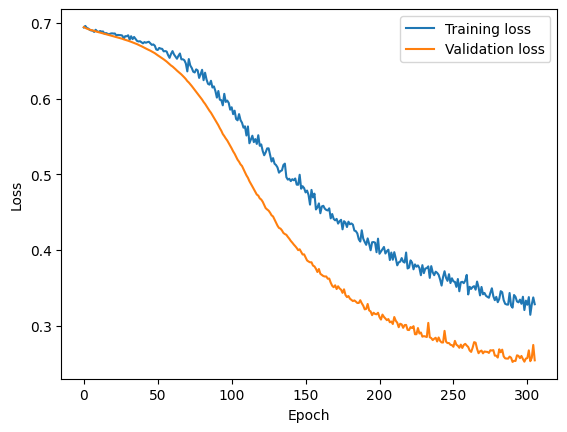

Finished Training
Accuracy score of this model: 0.8886010362694301
F1 score of this model: 0.8871391076115485
Recall score of this model: 0.8711340206185567
Precision score of this model: 0.9037433155080213
Total time is 44.92039513587952


In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

train_data = pd.read_csv("cure_the_princess_train.csv")
test_data = pd.read_csv("cure_the_princess_test.csv")
valid_data = pd.read_csv("cure_the_princess_validation.csv")
np.random.seed(190401037)
train_data = train_data.values
np.random.shuffle(train_data)

test_data = test_data.values
np.random.shuffle(test_data)

valid_data = valid_data.values
np.random.shuffle(valid_data)

x_train = train_data[:,:-1]
y_train = train_data[:,-1]

x_test = test_data[:,:-1]
y_test = test_data[:,-1]

x_valid = valid_data[:,:-1]
y_valid = valid_data[:,-1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1))

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))

x_valid = scaler.fit_transform(x_valid)
y_valid = scaler.fit_transform(y_valid.reshape(-1,1))


def df_to_torch(df, dtype = torch.float32):

  df = torch.tensor(df, dtype = dtype)
  return df

x_train = df_to_torch(x_train, dtype = torch.float32)
y_train = df_to_torch(y_train, dtype = torch.float32).reshape(-1,1)
x_test = df_to_torch(x_test, dtype = torch.float32)
y_test = df_to_torch(y_test,dtype = torch.float32).reshape(-1,1)
x_valid = df_to_torch(x_valid,dtype = torch.float32)
y_valid = df_to_torch(y_valid,dtype = torch.float32).reshape(-1,1)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.hidden = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.input(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.hidden(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.output(out)
        out = self.sigmoid(out)
        return out


input_size = x_train.shape[1] # 13 değer verileceği için shape[1] aldık
hidden_size1 = 100 # Açıklama gereği 100 nöron eklenecekti
hidden_size2 = 50 # açıklama gereği 50 nöron eklenecekti.
output_size = 1 # binary classification yaptığımızdan 1 nöron çıktısı elde edeceğiz.
    
model = MLP(input_size, hidden_size1, hidden_size2, output_size)


import torch.optim as optim
criterion = nn.BCELoss() # BinaryCrossEntropyLoss
optimizer = optim.SGD(model.parameters(), lr=0.01,weight_decay = 0.01) 
batch_size = 32
num_epochs = 1000
patience = 15

train_loss_list = []
val_loss_list = []
best_val_loss=None
patience_counter=0

import time
start = time.time()
seed_value = 190401037
torch.manual_seed(seed_value)

for epoch in range(num_epochs):
    epoch_train_loss = []
    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        epoch_train_loss.append(loss.item())

    train_loss = np.mean(epoch_train_loss)

    train_loss_list.append(train_loss)

    val_loss = 0.0

    with torch.no_grad():
        model.eval()
        for val_x, val_y in zip(x_valid,y_valid):
            outs = model(val_x)
            loss = criterion(outs, val_y)
            val_loss += loss.item()

    model.train()

  
    val_loss /= x_valid.shape[0]

    print("Epoch", epoch, "Training loss", train_loss,"Validation Loss :",val_loss)

    val_loss_list.append(val_loss)

    val_score = val_loss
    
    if best_val_loss is None:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: 
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") 
        patience_counter = 0
plt.plot(train_loss_list, label="Training loss")
plt.plot(val_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


print('Finished Training')
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()
predicts =[]
real_labels = list()
with torch.no_grad():
    for inputs,label in zip(x_test,y_test):
        outputs = model(inputs)
        predict = round(float(outputs.data))
        predicts.append(predict)
        real_labels.extend(label.tolist())
from sklearn.metrics import accuracy_score,f1_score,recall_score, precision_score
print("Accuracy score of this model: {}".format(accuracy_score(real_labels,predicts)))
print("F1 score of this model: {}".format(f1_score(real_labels,predicts)))
print("Recall score of this model: {}".format(recall_score(real_labels,predicts)))
print("Precision score of this model: {}".format(precision_score(real_labels,predicts)))
end = time.time()
print("Total time is {}".format(end-start))